# Frequently Asked Questions

Here we are attempting to answer some commonly asked questions that appear on Github, and Stack Overflow.

In [1]:
import featuretools as ft
import pandas as pd
import numpy as np

## EntitySet

### How do I get a list of variable (column) names, and types in an `EntitySet`?

After you create your `EntitySet`, you may wish to view the column names. An `EntitySet` contains multiple Dataframes, one for each entity.

In [2]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

If you want view the variables (columns), and types for the "transactions" entity, you can do the following:

In [3]:
es['transactions'].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = id)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: product_id (dtype = id)>]

If you want to view the underlying Dataframe, you can do the following:

In [4]:
es['transactions'].df.head()

,transaction_id,session_id,transaction_time,amount,product_id
298,298,1,2014-01-01 00:00:00,127.64,5
2,2,1,2014-01-01 00:01:05,109.48,2
308,308,1,2014-01-01 00:02:10,95.06,3
116,116,1,2014-01-01 00:03:15,78.92,4
371,371,1,2014-01-01 00:04:20,31.54,3


### What is the difference between **copy_variables** and **additional_variables**?
The function `normalize_entity` creates a new entity and a relationship from unique values of an existing entity. It takes 2 similar arguments:

- `additional_variables` removes variables from the base entity and moves them to the new entity. 
- `copy_variables` keeps the given variables in the base entity, but also copies them to the new entity.

In [5]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])
products_df = data["products"]

es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time")

es = es.entity_from_dataframe(entity_id="products",
                              dataframe=products_df,
                              index="product_id")

new_relationship = ft.Relationship(es["products"]["product_id"], es["transactions"]["product_id"])
es = es.add_relationship(new_relationship)

Before we normalize to create a new entity, let's look at base entity

In [6]:
es['transactions'].df.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
298,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
2,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
308,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
116,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
371,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18


Notice the columns `session_id`, `session_start`, `join_date`, `device`, `customer_id`, and `zip_code`.

In [7]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["join_date"],
                         copy_variables=["device", "customer_id", "zip_code","session_start"])

Above, we normalized the columns to create a new entity. 
- For `additional_variables`, the following column `['join_date]` will be removed from the `products` entity, and moved to the new `device` entity. 


- For `copy_variables`, the following columns `['device', 'customer_id', 'zip_code','session_start']` will be copied from the `products` entity to the new `device` entity. 

Let's see this in the actual `EntitySet`.

In [8]:
es['transactions'].df.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,date_of_birth
298,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,1986-08-18
2,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,1986-08-18
308,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,1986-08-18
116,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,1986-08-18
371,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,1986-08-18


Notice above how `['device', 'customer_id', 'zip_code','session_start']` are still in the `transactions` entity, while `['join_date']` is not. But, they have all been moved to the `sessions` entity, as seen below.

In [9]:
es['sessions'].df.head()

,session_id,join_date,device,customer_id,zip_code,session_start
1,1,2012-04-15 23:31:04,desktop,2,13244,2014-01-01 00:00:00
2,2,2010-07-17 05:27:50,mobile,5,60091,2014-01-01 00:17:20
3,3,2011-04-08 20:08:14,mobile,4,60091,2014-01-01 00:28:10
4,4,2011-04-17 10:48:33,mobile,1,60091,2014-01-01 00:44:25
5,5,2011-04-08 20:08:14,mobile,4,60091,2014-01-01 01:11:30


### Why did variable type change to Id, Index, or datetime_time_index?

During the creation of your `EntitySet`, you might be wondering why your variable type changed.

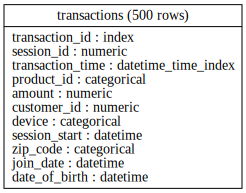

In [10]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])
products_df = data["products"]

es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time")
es.plot()

Notice how the variable type of `session_id` is Numeric, and the variable type of `session_start` is Datetime. 

Now, let's normalize the transactions entity to create a new entity.

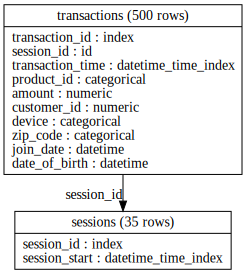

In [11]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["session_start"])
es.plot()

The type for `session_id` is now `Id` in the `transactions` entity, and `Index` in the new entity, `sessions`. This is the case because when we normalize the entity, we create a new relationship between the `transactions` and `sessions`. There is a one to many relationship between the parent entity, `sessions`, and child entity, `transactions`.

Therefore, `session_id` has type `Id` in `transactions` because it represents an `Index` in another entity. There would be a similar effect if we added another entity using `entity_from_dataframe` and `add_relationship`. 

In addition, when we created the new entity, we specified a `time_index` which was the variable (column) `session_start`. This changed the type of `session_start` to `datetime_time_index` in the new `sessions` entity because it now represents a time_index.

### How do I combine two or more interesting values?

You might want to create features that are conditioned on multiple values before they are calculated. This would require the use of `interesting_values`. However, since we are trying to create the feature with multiple conditions, we will need to modify the Dataframe before we create the `EntitySet`.

Let's look at how you might accomplish this. 

First, let's create our Dataframes.

In [12]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])
products_df = data["products"]

In [13]:
transactions_df.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
1,2,1,2014-01-01 00:01:05,2,109.48,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
2,308,1,2014-01-01 00:02:10,3,95.06,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
3,116,1,2014-01-01 00:03:15,4,78.92,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18
4,371,1,2014-01-01 00:04:20,3,31.54,2,desktop,2014-01-01,13244,2012-04-15 23:31:04,1986-08-18


In [14]:
products_df.head()

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


Now, let's modify our `transactions` Dataframe to create the additional column that represents multiple conditions for our feature.

In [15]:
transactions_df['product_id_device'] = transactions_df['product_id'].astype(str) + ' and ' + transactions_df['device']

Here, we created a new column called `product_id_device`, which just combines the `product_id` column, and the `device` column.

Now let's create our `EntitySet`.

In [16]:
es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time",
                              variable_types={"product_id": ft.variable_types.Categorical,
                                              "product_id_device": ft.variable_types.Categorical,
                                              "zip_code": ft.variable_types.ZIPCode})

es = es.entity_from_dataframe(entity_id="products",
                              dataframe=products_df,
                              index="product_id")
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         additional_variables=["device", "product_id_device", "customer_id"])
es = es.normalize_entity(base_entity_id="sessions",
                         new_entity_id="customers",
                         index="customer_id")
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 9]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 5]
    customers [Rows: 5, Columns: 2]
  Relationships:
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

Now, we are ready to add our interesting values. 

First, let's view our options for what the interesting values could be.

In [17]:
interesting_values = transactions_df['product_id_device'].unique().tolist()
interesting_values

['5 and desktop',
 '2 and desktop',
 '3 and desktop',
 '4 and desktop',
 '1 and desktop',
 '1 and tablet',
 '3 and tablet',
 '5 and tablet',
 '2 and tablet',
 '4 and tablet',
 '4 and mobile',
 '2 and mobile',
 '3 and mobile',
 '5 and mobile',
 '1 and mobile']

If you wanted to, you could pick a subset of these, and the `where` features created would only use those conditions. In our example, we will use all the possible interesting values.

Here, we set all of these values as our interesting values for this specific entity and variable. If we wanted to, we could make interesting values in the same way for more than one variable, but we will just stick with this one for this example.

In [18]:
es['sessions']['product_id_device'].interesting_values = interesting_values

Now we can run DFS.

In [19]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=["count"],
                                      where_primitives=["count"],
                                      trans_primitives=[])
feature_matrix.head()

,COUNT(sessions),COUNT(transactions),COUNT(sessions WHERE product_id_device = 4 and tablet),COUNT(sessions WHERE product_id_device = 4 and desktop),COUNT(sessions WHERE product_id_device = 2 and tablet),COUNT(sessions WHERE product_id_device = 4 and mobile),COUNT(sessions WHERE product_id_device = 1 and tablet),COUNT(sessions WHERE product_id_device = 5 and desktop),COUNT(sessions WHERE product_id_device = 5 and tablet),COUNT(sessions WHERE product_id_device = 2 and desktop),...,COUNT(transactions WHERE sessions.product_id_device = 3 and desktop),COUNT(transactions WHERE sessions.product_id_device = 4 and tablet),COUNT(transactions WHERE sessions.product_id_device = 4 and mobile),COUNT(transactions WHERE sessions.product_id_device = 1 and tablet),COUNT(transactions WHERE sessions.product_id_device = 5 and tablet),COUNT(transactions WHERE sessions.product_id_device = 1 and mobile),COUNT(transactions WHERE sessions.product_id_device = 2 and mobile),COUNT(transactions WHERE sessions.product_id_device = 3 and tablet),COUNT(transactions WHERE sessions.product_id_device = 5 and desktop),COUNT(transactions WHERE sessions.product_id_device = 1 and desktop)
customer_id,,,,,,,,,,,,,,,,,,,,,
2,7,93,0.0,1.0,0.0,1.0,1.0,1,1.0,0.0,...,0.0,0.0,18.0,15.0,13.0,0.0,13.0,0.0,16,8.0
5,6,79,1.0,1.0,0.0,1.0,0.0,1,0.0,0.0,...,0.0,14.0,10.0,0.0,0.0,18.0,0.0,0.0,15,0.0
4,8,109,0.0,1.0,0.0,0.0,0.0,1,1.0,1.0,...,0.0,0.0,0.0,0.0,18.0,15.0,23.0,0.0,10,0.0
1,8,126,2.0,0.0,0.0,3.0,0.0,1,0.0,1.0,...,0.0,27.0,56.0,0.0,0.0,0.0,0.0,16.0,12,0.0
3,6,93,0.0,0.0,1.0,0.0,0.0,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,33.0


To better understand the `where` clause features, let's examine one of those features. 
The feature `COUNT(sessions WHERE product_id_device = 5 and tablet)`, tells us how many sessions the customer purchased product_id 5 while on a tablet. Notice how the feature depends on multiple conditions **(product_id = 5 & device = tablet)**.

In [20]:
feature_matrix[["COUNT(sessions WHERE product_id_device = 5 and tablet)"]]

,COUNT(sessions WHERE product_id_device = 5 and tablet)
customer_id,
2,1.0
5,0.0
4,1.0
1,0.0
3,0.0


### Can I create entities and entitysets from Dask dataframes?

Yes! Featuretools supports creating entities and entitysets from Dask dataframes. The process used is the same as creating entities and entitysets from pandas dataframes.

There are some limitations to be aware of when using Dask dataframes. When creating an entity from a Dask dataframe, variable type inference is not performed as it is for pandas entities, so the user my supply a list of variable types when creating the entity. Also, other quality checks are not performed, such as checking for unique index values. Entitysets must be created entirely of Dask entities or pandas entities - you cannot mix pandas entities with Dask entitites in the same entitiyset.

For more information on creating entites and entitysets from Dask dataframes, see the [DFS with Dask Entitysets](https://docs.featuretools.com/en/stable/guides/dfs_with_dask_entitysets.html) guide.

## DFS

### Why is DFS not creating aggregation features?
You may have created your `EntitySet`, and then applied DFS to create features. However, you may be puzzled as to why no aggregation features were created. 

- **This is most likely because you have a single table in your entity, and DFS is not capable of creating aggregation features with fewer than 2 entities. Featuretools looks for a relationship, and aggregates based on that relationship.**

Let's look at a simple example.

In [21]:
data = ft.demo.load_mock_customer()
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])

es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id")
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

Notice how we only have 1 entity in our `EntitySet`. If we try to create aggregation features on this `EntitySet`, it will not be possible because DFS needs 2 entities to generate aggregation features. 

In [22]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="transactions")
feature_defs

[<Feature: session_id>,
 <Feature: product_id>,
 <Feature: amount>,
 <Feature: customer_id>,
 <Feature: device>,
 <Feature: zip_code>,
 <Feature: DAY(join_date)>,
 <Feature: DAY(transaction_time)>,
 <Feature: DAY(session_start)>,
 <Feature: DAY(date_of_birth)>,
 <Feature: YEAR(join_date)>,
 <Feature: YEAR(transaction_time)>,
 <Feature: YEAR(session_start)>,
 <Feature: YEAR(date_of_birth)>,
 <Feature: MONTH(join_date)>,
 <Feature: MONTH(transaction_time)>,
 <Feature: MONTH(session_start)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: WEEKDAY(join_date)>,
 <Feature: WEEKDAY(transaction_time)>,
 <Feature: WEEKDAY(session_start)>,
 <Feature: WEEKDAY(date_of_birth)>]

None of the above features are aggregation features. To fix this issue, you can add another entity to your `EntitySet`.

**Solution #1 - You can add new entity if you have additional data.**

In [23]:
products_df = data["products"]
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=products_df,
                              index="product_id")
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    No relationships

Notice how we now have an additional entity in our `EntitySet`, called `products`.

**Solution #2 - You can normalize an existing entity.**

In [24]:
es = es.normalize_entity(base_entity_id="transactions",
                         new_entity_id="sessions",
                         index="session_id",
                         make_time_index="session_start",
                         additional_variables=["device", "customer_id", "zip_code", "join_date"],
                         copy_variables=["session_start"])
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 7]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 6]
  Relationships:
    transactions.session_id -> sessions.session_id

Notice how we now have an additional entity in our `EntitySet`, called `sessions`. Here, the normalization created a relationship between `transactions` and `sessions`. However, we could have specified a relationship between `transactions` and `products` if we had only used Solution \#1.

Now, we can generate aggregation features.

In [25]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="transactions")
feature_defs[:-10]

[<Feature: session_id>,
 <Feature: product_id>,
 <Feature: amount>,
 <Feature: DAY(transaction_time)>,
 <Feature: DAY(session_start)>,
 <Feature: DAY(date_of_birth)>,
 <Feature: YEAR(transaction_time)>,
 <Feature: YEAR(session_start)>,
 <Feature: YEAR(date_of_birth)>,
 <Feature: MONTH(transaction_time)>,
 <Feature: MONTH(session_start)>,
 <Feature: MONTH(date_of_birth)>,
 <Feature: WEEKDAY(transaction_time)>,
 <Feature: WEEKDAY(session_start)>,
 <Feature: WEEKDAY(date_of_birth)>,
 <Feature: sessions.device>,
 <Feature: sessions.customer_id>,
 <Feature: sessions.zip_code>,
 <Feature: sessions.SUM(transactions.amount)>,
 <Feature: sessions.STD(transactions.amount)>,
 <Feature: sessions.MAX(transactions.amount)>,
 <Feature: sessions.SKEW(transactions.amount)>,
 <Feature: sessions.MIN(transactions.amount)>,
 <Feature: sessions.MEAN(transactions.amount)>,
 <Feature: sessions.COUNT(transactions)>]

A few of the aggregation features are:

- `<Feature: sessions.SUM(transactions.amount)>`
- `<Feature: sessions.STD(transactions.amount)>`
- `<Feature: sessions.MAX(transactions.amount)>`
- `<Feature: sessions.SKEW(transactions.amount)>`
- `<Feature: sessions.MIN(transactions.amount)>`
- `<Feature: sessions.MEAN(transactions.amount)>`
- `<Feature: sessions.COUNT(transactions)>`

### How do I speed up the runtime of DFS?

One issue you may encounter while running `ft.dfs` is slow performance. While Featuretools has generally optimal default settings for calculating features, you may want to speed up performance when you are calculating on a large number of features. 

One quick way to speed up performance is by adjusting the `n_jobs` settings of `ft.dfs` or `ft.calculate_feature_matrix`.

```python
# setting n_jobs to -1 will use all cores

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      n_jobs=-1)

                                      
feature_matrix, feature_defs = ft.calculate_feature_matrix(entityset=es,
                                                           features=feature_defs,
                                                           n_jobs=-1)
```


**For more ways to speed up performance, please visit:**

- [Improving Computational Performance](./guides/performance.rst#improving-computational-performance)

### How do I include only certain features when running DFS?

When using DFS to generate features, you may wish to include only certain features. There are multiple ways that you do this:

- Use the `ignore_variables` to specify variables in an entity that should not be used to create features. It is a dictionary mapping an entity id to a list of variable names to ignore.

- Use `drop_contains` to drop features that contain any of the strings listed in this parameter.

- Use `drop_exact` to drop features that exactly match any of the strings listed in this parameter.

Here is an example of using all three parameters:

In [26]:
es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      ignore_variables={
                                           "transactions": ["amount"],
                                           "customers": ["age", "gender", "date_of_birth"]
                                       }, # ignore these variables
                                      drop_contains=["customers.SUM("], # drop features that contain these strings
                                      drop_exact=["STD(transactions.quanity)"]) # drop features that exactly match

### How do I specify primitives on a per column or per entity basis?

When using DFS to generate features, you may wish to use only certain features or entities for specific primitives. This can be done through the `primitive_options` parameter. The `primitive_options` parameter is a dictionary or list of dictionaries that maps a primitive or a tuple of primitives to a dictionary containing options for the primitive(s). This parameter can also be a list of option dictionaries if the primitive 
takes multiple inputs. Each dictionary supplies options for their respective input column. There are multiple ways to control how primitives get applied through these options:

- Use `ignore_entities` to specify entities that should not be used to create features for that primitive. It is a list of entity ids to ignore.

- Use `include_entities` to specify the only entities to be included to create features for that primitive. It is a list of entity ids to include.

- Use `ignore_variables` to specify variables in an entity that should not be used to create features for that primitive. It is a dictionary mapping an entity id to a list of variable names to ignore.

- Use `include_variables` to specify the only variables in an entity that should be used to create features for that primitive. It is a dictionary mapping an entity id to a list of variable names to include.

You can also use `primitive_options` to specify which entities or variables you wish to use as groupbys for groupby transformation primitives:

- Use `ignore_groupby_entities` to specify entities that should not be used to get groupbys for that primitive. It is a list of entity ids to ignore.

- Use `include_groupby_entities` to specify the only entities that should be used to get groupbys for that primitive. It is a list of entity ids to include.

- Use `ignore_groupby_variables` to specify variables in an entity that should not be used as groupbys for that primitive. It is a dictionary mapping an entity id to a list of variable names to ignore.

- Use `include_groupby_variables` to specify the only variables in an entity that should be used as groupbys for that primitive. It is a dictionary mapping an entity id to a list of variable names to include.

Here is an example of using some of these options:

In [27]:
es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      primitive_options={"mode": {"ignore_entities": ["sessions"],
                                                                  "include_variables": {"products": ["brand"],
                                                                                        "transactions": ["product_id"]}},
                                                         # For mode, ignore the "sessions" entity and only include "brands" in the
                                                         # "products" entity and "product_id" in the "transactions" entity
                                                         ("count", "mean"): {"include_entities": ["sessions", "transactions"]}
                                                         # For count and mean, only include the entities "sessions" and "transactions"
                                                         })


**For a more examples of specifying options for DFS, please visit:**

- [Specifying Primitive Options](guides/specifying_primitive_options.rst)

### If I didn't specify the **cutoff_time**, what date will be used for the feature calculations?

The cutoff time will be set to the current time using `cutoff_time = datetime.now()`.

### How do I select a certain amount of past data when calculating features?

You may encounter a situation when you wish to make prediction using only a certain amount of historical data. You can accomplish this using the `training_window` parameter in `ft.dfs`. When you use the `training_window`, Featuretools will use the historical data between the `cutoff_time` and `cutoff_time - training_window`.

In order to make the calculation, Featuretools will check the time in the `time_index` column of the `target_entity`.

In [28]:
es = ft.demo.load_mock_customer(return_entityset=True)
es['customers'].time_index

'join_date'

Our target_entity has a `time_index`, which is needed for the `training_window` calculation. Here, we are creating a cutoff time dataframe so that we can have a unique training window for each customer.

In [29]:
cutoff_times = pd.DataFrame()
cutoff_times['customer_id'] = [1, 2, 3, 1]
cutoff_times['time'] = pd.to_datetime(['2014-1-1 04:00', '2014-1-1 05:00', '2014-1-1 06:00', '2014-1-1 08:00'])
cutoff_times['label'] = [True, True, False, True]

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      cutoff_time=cutoff_times,
                                      cutoff_time_in_index=True,
                                      training_window="1 hour")
feature_matrix.head()

,,zip_code,COUNT(sessions),NUM_UNIQUE(sessions.device),MODE(sessions.device),SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),...,MODE(sessions.WEEKDAY(session_start)),MODE(sessions.MONTH(session_start)),MODE(sessions.MODE(transactions.product_id)),MODE(sessions.DAY(session_start)),MODE(sessions.YEAR(session_start)),NUM_UNIQUE(transactions.sessions.device),NUM_UNIQUE(transactions.sessions.customer_id),MODE(transactions.sessions.device),MODE(transactions.sessions.customer_id),label
customer_id,time,,,,,,,,,,,,,,,,,,,,,
1,2014-01-01 04:00:00,60091,1,1,tablet,1025.63,39.825249,139.09,-0.830975,6.78,85.469167,...,2,1,4,1,2014,1,1,tablet,1,True
2,2014-01-01 05:00:00,13244,1,1,tablet,1004.96,33.725036,118.85,-0.314918,21.82,77.304615,...,2,1,1,1,2014,1,1,tablet,2,True
3,2014-01-01 06:00:00,13244,2,1,desktop,980.97,34.188788,128.26,-0.386592,20.06,81.747500,...,2,1,1,1,2014,1,1,desktop,3,False
1,2014-01-01 08:00:00,60091,1,1,mobile,1420.09,32.324534,126.11,-1.038434,11.62,88.755625,...,2,1,4,1,2014,1,1,mobile,1,True


Above, we ran DFS with `training_window` argument of `1 hour` to create features that only used customer data collected in the last hour (from the cutoff time we provided).

### How do I apply DFS to a single table?

You can run DFS on a single table. Featuretools will be able to generate features for your data, but only transform features.

For example:

In [30]:
transactions_df = ft.demo.load_mock_customer(return_single_table=True)

es = ft.EntitySet(id="customer_data")
es = es.entity_from_dataframe(entity_id="transactions",
                              dataframe=transactions_df,
                              index="transaction_id",
                              time_index="transaction_time")

feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_entity="transactions", 
                                      trans_primitives=['time_since', 'day', 'is_weekend', 
                                                        'cum_min', 'minute', 
                                                        'num_words', 'weekday', 'cum_count', 
                                                        'percentile', 'year', 'week',
                                                        'cum_mean'])

Before we examine the output, let's look at our original single table.

In [31]:
transactions_df.head()

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth,brand
0,298,1,2014-01-01 00:00:00,5,127.64,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18,A
1,10,1,2014-01-01 00:09:45,5,57.39,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18,A
2,495,1,2014-01-01 00:14:05,5,69.45,2,desktop,2014-01-01 00:00:00,13244,2012-04-15 23:31:04,1986-08-18,A
3,460,10,2014-01-01 02:33:50,5,123.19,2,tablet,2014-01-01 02:31:40,13244,2012-04-15 23:31:04,1986-08-18,A
4,302,10,2014-01-01 02:37:05,5,64.47,2,tablet,2014-01-01 02:31:40,13244,2012-04-15 23:31:04,1986-08-18,A


Now we can look at the transformations that Featuretools was able to apply to this single entity (table) to create feature matrix.

In [32]:
feature_matrix.head()

,session_id,product_id,amount,customer_id,device,zip_code,brand,TIME_SINCE(transaction_time),DAY(join_date),DAY(transaction_time),...,CUM_MEAN(MINUTE(join_date)),CUM_MEAN(PERCENTILE(amount)),CUM_MEAN(MINUTE(session_start)),CUM_MEAN(MINUTE(transaction_time)),CUM_MEAN(CUM_MIN(customer_id)),CUM_MEAN(MINUTE(date_of_birth)),CUM_MEAN(PERCENTILE(customer_id)),CUM_MEAN(CUM_MIN(session_id)),CUM_MEAN(CUM_MIN(amount)),CUM_MEAN(PERCENTILE(session_id))
transaction_id,,,,,,,,,,,,,,,,,,,,,
298,1,5,127.64,2,desktop,13244,A,2.008325e+08,15,1,...,31.0,0.846000,0.0,0.0,2.0,0.0,0.346,1.0,127.640000,0.017
2,1,2,109.48,2,desktop,13244,B,2.008324e+08,15,1,...,31.0,0.793000,0.0,0.5,2.0,0.0,0.346,1.0,118.560000,0.017
308,1,3,95.06,2,desktop,13244,B,2.008324e+08,15,1,...,31.0,0.743333,0.0,1.0,2.0,0.0,0.346,1.0,110.726667,0.017
116,1,4,78.92,2,desktop,13244,B,2.008323e+08,15,1,...,31.0,0.693500,0.0,1.5,2.0,0.0,0.346,1.0,102.775000,0.017
371,1,3,31.54,2,desktop,13244,B,2.008322e+08,15,1,...,31.0,0.597200,0.0,2.0,2.0,0.0,0.346,1.0,88.528000,0.017


### Can I automatically normalize a single table?

Yes, another open source library [AutoNormalize](https://github.com/FeatureLabs/autonormalize), also produced by Feature Labs, automates table normalization and integrates with Featuretools. To install run:

```shell
python -m pip install featuretools[autonormalize]
```

A normalized `EntitySet` will help Featuretools to generate more features. For example:

100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


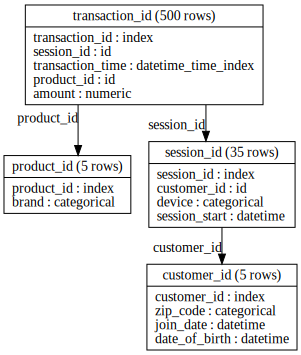

In [33]:
from featuretools.autonormalize import autonormalize as an
es = an.normalize_entity(es)
es.plot()

As you can see, AutoNormalize creates a relational `EntitySet`. Below, we run dfs on the `EntitySet`, and you can see all the features created; take note of the aggregated features.

In [34]:
feature_matrix, feature_defs = ft.dfs(entityset=es, 
                                      target_entity="transaction_id", 
                                      trans_primitives=[])
feature_matrix.head()

,session_id,product_id,amount,session_id.customer_id,session_id.device,product_id.brand,session_id.SUM(transaction_id.amount),session_id.STD(transaction_id.amount),session_id.MAX(transaction_id.amount),session_id.SKEW(transaction_id.amount),...,session_id.customer_id.zip_code,product_id.SUM(transaction_id.amount),product_id.STD(transaction_id.amount),product_id.MAX(transaction_id.amount),product_id.SKEW(transaction_id.amount),product_id.MIN(transaction_id.amount),product_id.MEAN(transaction_id.amount),product_id.COUNT(transaction_id),product_id.NUM_UNIQUE(transaction_id.session_id),product_id.MODE(transaction_id.session_id)
transaction_id,,,,,,,,,,,,,,,,,,,,,
298,1,5,127.64,2,desktop,A,1229.01,41.600976,141.66,0.295458,...,13244,7931.55,42.131902,149.02,0.098248,5.91,76.264904,104,34,4
2,1,2,109.48,2,desktop,B,1229.01,41.600976,141.66,0.295458,...,13244,7021.43,46.336308,149.95,0.151934,5.73,76.319891,92,34,28
308,1,3,95.06,2,desktop,B,1229.01,41.600976,141.66,0.295458,...,13244,7008.12,38.871405,148.31,0.223938,5.89,73.001250,96,35,1
116,1,4,78.92,2,desktop,B,1229.01,41.600976,141.66,0.295458,...,13244,8088.97,42.492501,146.46,-0.132077,5.81,76.311038,106,34,29
371,1,3,31.54,2,desktop,B,1229.01,41.600976,141.66,0.295458,...,13244,7008.12,38.871405,148.31,0.223938,5.89,73.001250,96,35,1


### How do I prevent label leakage with DFS?

One concern you might have with using DFS is about label leakage. You want to make sure that labels in your data aren't used incorrectly to create features and the feature matrix.

**Featuretools is particularly focused on helping users avoid label leakage.**

There are two ways to prevent label leakage depending on if your data has timestamps or not.

#### 1. Data without timestamps
In the case where you do not have timestamps, you can create one `EntitySet` using only the training data and then run `ft.dfs`. This will create a feature matrix using only the training data, but also return a list of feature definitions. Next, you can create an `EntitySet` using the test data and recalculate the same features by calling `ft.calculate_feature_matrix` with the list of feature definitions from before. 

Here is what that flow would look like:

First, let's create our training data.

In [35]:
train_data = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                           "age": [40, 50, 10, 20, 30],
                           "gender": ["m", "f", "m", "f", "f"],
                           "signup_date": pd.date_range('2014-01-01 01:41:50', periods=5, freq='25min'),
                           "labels": [True, False, True, False, True]})
train_data.head()

,customer_id,age,gender,signup_date,labels
0,1,40,m,2014-01-01 01:41:50,True
1,2,50,f,2014-01-01 02:06:50,False
2,3,10,m,2014-01-01 02:31:50,True
3,4,20,f,2014-01-01 02:56:50,False
4,5,30,f,2014-01-01 03:21:50,True


Now, we can create an entityset for our training data.

In [36]:
es_train_data = ft.EntitySet(id="customer_train_data")
es_train_data = es_train_data.entity_from_dataframe(entity_id="customers",
                                                    dataframe=train_data,
                                                    index="customer_id")
es_train_data

Entityset: customer_train_data
  Entities:
    customers [Rows: 5, Columns: 5]
  Relationships:
    No relationships

Next, we are ready to create our features, and feature matrix for the training data.

In [37]:
feature_matrix_train, feature_defs = ft.dfs(entityset=es_train_data, 
                                            target_entity="customers")
feature_matrix_train

,age,gender,labels,DAY(signup_date),YEAR(signup_date),MONTH(signup_date),WEEKDAY(signup_date)
customer_id,,,,,,,
1,40,m,True,1,2014,1,2
2,50,f,False,1,2014,1,2
3,10,m,True,1,2014,1,2
4,20,f,False,1,2014,1,2
5,30,f,True,1,2014,1,2


We will also encode our feature matrix to make machine learning compatible features. 

In [38]:
feature_matrix_train_enc, features_enc = ft.encode_features(feature_matrix_train, feature_defs)
feature_matrix_train_enc.head()

,age,gender = f,gender = m,gender is unknown,labels,DAY(signup_date) = 1,DAY(signup_date) is unknown,YEAR(signup_date) = 2014,YEAR(signup_date) is unknown,MONTH(signup_date) = 1,MONTH(signup_date) is unknown,WEEKDAY(signup_date) = 2,WEEKDAY(signup_date) is unknown
customer_id,,,,,,,,,,,,,
1,40,0,1,0,True,1,0,1,0,1,0,1,0
2,50,1,0,0,False,1,0,1,0,1,0,1,0
3,10,0,1,0,True,1,0,1,0,1,0,1,0
4,20,1,0,0,False,1,0,1,0,1,0,1,0
5,30,1,0,0,True,1,0,1,0,1,0,1,0


Notice how the the whole feature matrix only inclues numeric values now.

Now we can use the feature definitions to calculate our feature matrix for the test data, and avoid label leakage.

In [39]:
test_train = pd.DataFrame({"customer_id": [6, 7, 8, 9, 10],
                           "age": [20, 25, 55, 22, 35],
                           "gender": ["f", "m", "m", "m", "m"],
                           "signup_date": pd.date_range('2014-01-01 01:41:50', periods=5, freq='25min')})

# lets add NaN label column to the test Dataframe
test_train['labels'] = np.nan

es_test_data = ft.EntitySet(id="customer_test_data")
es_test_data = es_test_data.entity_from_dataframe(entity_id="customers",
                                                  dataframe=test_train,
                                                  index="customer_id",
                                                  time_index="signup_date")

# Use the feature definitions from earlier
feature_matrix_enc_test = ft.calculate_feature_matrix(features=features_enc, 
                                                      entityset=es_test_data)

feature_matrix_enc_test.head()

,age,gender = f,gender = m,gender is unknown,labels,DAY(signup_date) = 1,DAY(signup_date) is unknown,YEAR(signup_date) = 2014,YEAR(signup_date) is unknown,MONTH(signup_date) = 1,MONTH(signup_date) is unknown,WEEKDAY(signup_date) = 2,WEEKDAY(signup_date) is unknown
customer_id,,,,,,,,,,,,,
6,20,True,False,False,NaN,True,False,True,False,True,False,True,False
7,25,False,True,False,NaN,True,False,True,False,True,False,True,False
8,55,False,True,False,NaN,True,False,True,False,True,False,True,False
9,22,False,True,False,NaN,True,False,True,False,True,False,True,False
10,35,False,True,False,NaN,True,False,True,False,True,False,True,False


> Note: Disregard the difference between the False/True above, and 0/1 in the earlier feature matrix. A simple casting would address this difference.

#### 2. Data with timestamps

If your data has timestamps, the best way to prevent label leakage is to use a list of **cutoff times**, which specify the last point in time data is allowed to be used for each row in the resulting feature matrix. To use **cutoff times**, you need to set a time index for each time sensitive entity in your entity set.

> **Tip: Even if your data doesn’t have time stamps, you could add a column with dummy timestamps that can be used by Featuretools as time index.**

When you call `ft.dfs`, you can provide a Dataframe of cutoff times like this:

In [40]:
cutoff_times = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                             "time": pd.date_range('2014-01-01 01:41:50', periods=5, freq='25min')})
cutoff_times.head()

,customer_id,time
0,1,2014-01-01 01:41:50
1,2,2014-01-01 02:06:50
2,3,2014-01-01 02:31:50
3,4,2014-01-01 02:56:50
4,5,2014-01-01 03:21:50


In [41]:
train_test_data = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                                "age": [20, 25, 55, 22, 35],
                                "gender": ["f", "m", "m", "m", "m"],
                                "signup_date": pd.date_range('2010-01-01 01:41:50', periods=5, freq='25min')})

es_train_test_data = ft.EntitySet(id="customer_train_test_data")
es_train_test_data = es_train_test_data.entity_from_dataframe(entity_id="customers",
                                                              dataframe=train_test_data,
                                                              index="customer_id",
                                                              time_index="signup_date")

feature_matrix_train_test, features = ft.dfs(entityset=es_train_test_data,
                                             target_entity="customers",
                                             cutoff_time=cutoff_times,
                                             cutoff_time_in_index=True)
feature_matrix_train_test.head()

,,age,gender,DAY(signup_date),YEAR(signup_date),MONTH(signup_date),WEEKDAY(signup_date)
customer_id,time,,,,,,
1,2014-01-01 01:41:50,20,f,1,2010,1,4
2,2014-01-01 02:06:50,25,m,1,2010,1,4
3,2014-01-01 02:31:50,55,m,1,2010,1,4
4,2014-01-01 02:56:50,22,m,1,2010,1,4
5,2014-01-01 03:21:50,35,m,1,2010,1,4


Above, we have created a feature matrix that uses cutoff times to avoid label leakage. We could also encode this feature matrix using `ft.encode_features`.

### What is the difference between passing a primitive object versus a string to DFS?  

There are 2 ways to pass primitives to DFS: the primitive object, or a string of the primitive name. 

We will use the Transform primitive called `TimeSincePrevious` to illustrate the differences.

First, let's use the string of primitive name.

In [42]:
es = ft.demo.load_mock_customer(return_entityset=True)

In [43]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=[],
                                      trans_primitives=["time_since_previous"])
feature_matrix

,zip_code,TIME_SINCE_PREVIOUS(join_date)
customer_id,,
5,60091,NaN
4,60091,22948824.0
1,60091,744019.0
3,13244,10212841.0
2,13244,21282510.0


Now, let's use the primitive object.

In [44]:
from featuretools.primitives import TimeSincePrevious

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=[],
                                      trans_primitives=[TimeSincePrevious])
feature_matrix

,zip_code,TIME_SINCE_PREVIOUS(join_date)
customer_id,,
5,60091,NaN
4,60091,22948824.0
1,60091,744019.0
3,13244,10212841.0
2,13244,21282510.0


As we can see above, the feature matrix is the same.

However, if we need to modify controllable parameters in the primitive, we should use the primitive object. 
For instance, let's make TimeSincePrevious return units of hours (the default is in seconds).

In [45]:
from featuretools.primitives import TimeSincePrevious

time_since_previous_in_hours = TimeSincePrevious(unit='hours')

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=[],
                                      trans_primitives=[time_since_previous_in_hours])
feature_matrix

,zip_code,"TIME_SINCE_PREVIOUS(join_date, unit=hours)"
customer_id,,
5,60091,NaN
4,60091,6374.673333
1,60091,206.671944
3,13244,2836.900278
2,13244,5911.808333


## Features

### How can I select features based on some attributes (a specific string, an explicit primitive type, a return type, a given depth)?

You may wish to select a subset of your features based on some attributes. 

Let's say you wanted to select features that had the string `amount` in its name. You can check for this by using the `get_name` function on the feature definitions.

In [46]:
es = ft.demo.load_mock_customer(return_entityset=True)

feature_defs = ft.dfs(entityset=es,
                      target_entity="customers",
                      features_only=True)

features_with_amount = []
for x in feature_defs:
    if 'amount' in x.get_name():
        features_with_amount.append(x)
features_with_amount[0:5]

[<Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: MAX(transactions.amount)>,
 <Feature: SKEW(transactions.amount)>,
 <Feature: MIN(transactions.amount)>]

You might also want to only select features that are aggregation features.

In [47]:
from featuretools import AggregationFeature

features_only_aggregations = []
for x in feature_defs:
    if type(x) == AggregationFeature:
        features_only_aggregations.append(x)
features_only_aggregations[0:5]

[<Feature: COUNT(sessions)>,
 <Feature: NUM_UNIQUE(sessions.device)>,
 <Feature: MODE(sessions.device)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>]

Also, you might only want to select features that are calculated at a certain depth. You can do this by using the `get_depth` function. 

In [48]:
features_only_depth_2 = []
for x in feature_defs:
    if x.get_depth() == 2:
        features_only_depth_2.append(x)
features_only_depth_2[0:5]

[<Feature: SUM(sessions.STD(transactions.amount))>,
 <Feature: SUM(sessions.MEAN(transactions.amount))>,
 <Feature: SUM(sessions.MIN(transactions.amount))>,
 <Feature: SUM(sessions.MAX(transactions.amount))>,
 <Feature: SUM(sessions.NUM_UNIQUE(transactions.product_id))>]

Finally, you might only want features that return a certain type. You can do this by using the `variable_type` function.

In [49]:
from featuretools.variable_types import Numeric

features_only_numeric = []
for x in feature_defs:
    if x.variable_type == Numeric:
        features_only_numeric.append(x)
features_only_numeric[0:5]

[<Feature: COUNT(sessions)>,
 <Feature: NUM_UNIQUE(sessions.device)>,
 <Feature: SUM(transactions.amount)>,
 <Feature: STD(transactions.amount)>,
 <Feature: MAX(transactions.amount)>]

Once you have your specific feature list, you can use `ft.calculate_feature_matrix` to generate a feature matrix for only those features.

For our example, let's use the features with only the string `amount` in its name.

In [50]:
feature_matrix = ft.calculate_feature_matrix(entityset=es,
                                             features=features_with_amount) # change to your specific feature list
feature_matrix.head()

,SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),SUM(sessions.STD(transactions.amount)),SUM(sessions.MEAN(transactions.amount)),SUM(sessions.MIN(transactions.amount)),SUM(sessions.MAX(transactions.amount)),...,MIN(sessions.STD(transactions.amount)),MIN(sessions.MEAN(transactions.amount)),MIN(sessions.MAX(transactions.amount)),MIN(sessions.SKEW(transactions.amount)),MEAN(sessions.SUM(transactions.amount)),MEAN(sessions.STD(transactions.amount)),MEAN(sessions.MEAN(transactions.amount)),MEAN(sessions.MIN(transactions.amount)),MEAN(sessions.MAX(transactions.amount)),MEAN(sessions.SKEW(transactions.amount))
customer_id,,,,,,,,,,,,,,,,,,,,,
5,6349.66,44.095630,149.02,-0.025941,7.55,80.375443,259.873954,472.231119,86.49,839.76,...,36.734681,66.666667,128.51,-0.539060,1058.276667,43.312326,78.705187,14.415000,139.960000,0.002397
4,8727.68,45.068765,149.95,-0.036348,5.73,80.070459,356.125829,649.657515,131.51,1157.99,...,29.026424,70.638182,139.20,-0.711744,1090.960000,44.515729,81.207189,16.438750,144.748750,0.000346
1,9025.62,40.442059,139.43,0.019698,5.81,71.631905,312.745952,582.193117,78.59,1057.97,...,30.450261,50.623125,118.90,-1.038434,1128.202500,39.093244,72.774140,9.823750,132.246250,-0.059515
3,6236.62,43.683296,149.15,0.418230,5.89,67.060430,257.299895,405.237462,66.21,847.63,...,35.704680,55.579412,126.74,-0.289466,1039.436667,42.883316,67.539577,11.035000,141.271667,0.381014
2,7200.28,37.705178,146.81,0.098259,8.73,77.422366,258.700528,548.905851,154.60,931.63,...,27.839228,61.910000,100.04,-0.763603,1028.611429,36.957218,78.415122,22.085714,133.090000,-0.039663


Above, notice how all the column names for our feature matrix contain the string `amount`.

### How do I create **where** features?

Sometimes, you might want to create features that are conditioned on a second value before it is calculated. This extra filter is called a “where clause”. You can create these features using the using the `interesting_values` of a variable.

If you have categorical columns in your `EntitySet`, you can use then `add_interesting_values`. This function will  find interesting values for your categorical variables, which can then be used to generate “where” clauses.

First, let's create our `EntitySet`.

In [51]:
es = ft.demo.load_mock_customer(return_entityset=True)
es

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

Now we can add the interesting variables for the categorical variables.

In [52]:
es.add_interesting_values()

Now we can run DFS with the `where_primitives` argument to define which primitives to apply with where clauses. In this case, let's use the primitive `count`.

In [53]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=["count"],
                                      where_primitives=["count"],
                                      trans_primitives=[])
feature_matrix.head()

,zip_code,COUNT(sessions),COUNT(transactions),COUNT(sessions WHERE device = desktop),COUNT(sessions WHERE device = mobile),COUNT(sessions WHERE device = tablet),COUNT(sessions WHERE customers.zip_code = 13244),COUNT(sessions WHERE customers.zip_code = 60091),COUNT(transactions WHERE sessions.device = mobile),COUNT(transactions WHERE sessions.device = tablet),COUNT(transactions WHERE sessions.device = desktop)
customer_id,,,,,,,,,,,
5,60091,6,79,2,3,1,0.0,6.0,36,14,29
4,60091,8,109,3,4,1,0.0,8.0,53,18,38
1,60091,8,126,2,3,3,0.0,8.0,56,43,27
3,13244,6,93,4,1,1,6.0,0.0,16,15,62
2,13244,7,93,3,2,2,7.0,0.0,31,28,34


We have now created some useful features. One example of a useful feature is the `COUNT(sessions WHERE device = tablet)`. This feature tells us how many sessions a customer completed on a tablet.

In [54]:
feature_matrix[["COUNT(sessions WHERE device = tablet)"]]

,COUNT(sessions WHERE device = tablet)
customer_id,
5,1
4,1
1,3
3,1
2,2


## Primitives

### What is the difference between the primitive types (Transform, GroupBy Transform, & Aggregation)?

You might curious to know the difference between the primitive groups.
Let's review the differences between transform, groupby transform, and aggregation primitives.

First, let's create a simple `EntitySet`.

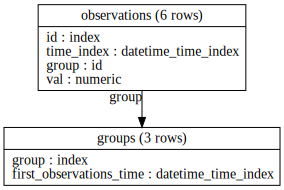

In [55]:
import pandas as pd
import featuretools as ft

df = pd.DataFrame({
    "id": [1, 2, 3, 4, 5, 6],
    "time_index": pd.date_range("1/1/2019", periods=6, freq="D"),
    "group": ["a", "b", "a", "c", "a", "b"],
    "val": [5, 1, 10, 20, 6, 23],
})
es = ft.EntitySet()
es = es.entity_from_dataframe(entity_id="observations",
                              dataframe=df,
                              index="id",
                              time_index="time_index")

es = es.normalize_entity(base_entity_id="observations",
                         new_entity_id="groups",
                         index="group")

es.plot()

After calling normalize_entity, the variable "group" has the type "id" because it identifies another entity. Alternatively, it could be set using the variable_types parameter when we first call `es.entity_from_dataframe()`.

#### Transform Primitive

The cum_sum primitive calculates the running sum in list of numbers.

In [56]:
from featuretools.primitives import CumSum

cum_sum = CumSum()
cum_sum([1, 2, 3, 4, 5]).tolist()

[1, 3, 6, 10, 15]

If we apply it using the trans_primitives argument it will calculate it over the entire observations entity like this:

In [57]:
feature_matrix, feature_defs = ft.dfs(target_entity="observations",
                                      entityset=es,
                                      agg_primitives=[],
                                      trans_primitives=["cum_sum"],
                                      groupby_trans_primitives=[])

feature_matrix

,group,val,CUM_SUM(val)
id,,,
1,a,5,5
2,b,1,6
3,a,10,16
4,c,20,36
5,a,6,42
6,b,23,65


#### Groupby Transform Primitive

If we apply it using `groupby_trans_primitives`, then DFS will first group by any id variables before applying the transform primitive. As a result, we get the cumulative sum by group.

In [58]:
feature_matrix, feature_defs = ft.dfs(target_entity="observations",
                                      entityset=es,
                                      agg_primitives=[],
                                      trans_primitives=[],
                                      groupby_trans_primitives=["cum_sum"])

feature_matrix

,group,val,CUM_SUM(val) by group
id,,,
1,a,5,5.0
2,b,1,1.0
3,a,10,15.0
4,c,20,20.0
5,a,6,21.0
6,b,23,24.0


#### Aggregation Primitive

Finally, there is also the aggregation primitive "sum". If we use sum, it will calculate the sum for the group at the cutoff time for each row. Because we didn't specify a cutoff time it will use all the data for each group for each row.

In [59]:
feature_matrix, feature_defs = ft.dfs(target_entity="observations",
                                      entityset=es,
                                      agg_primitives=["sum"],
                                      trans_primitives=[],
                                      cutoff_time_in_index=True,
                                      groupby_trans_primitives=[])

feature_matrix

,,group,val,groups.SUM(observations.val)
id,time,,,
1,2020-05-13 10:48:24.157178,a,5,21
2,2020-05-13 10:48:24.157178,b,1,24
3,2020-05-13 10:48:24.157178,a,10,21
4,2020-05-13 10:48:24.157178,c,20,20
5,2020-05-13 10:48:24.157178,a,6,21
6,2020-05-13 10:48:24.157178,b,23,24


If we set the cutoff time of each row to be the time index, then use sum as an aggregation primitive, the result is the same as cum_sum. (Though the order is different in the displayed dataframe).

In [60]:
cutoff_time = df[["id", "time_index"]]
cutoff_time

,id,time_index
0,1,2019-01-01
1,2,2019-01-02
2,3,2019-01-03
3,4,2019-01-04
4,5,2019-01-05
5,6,2019-01-06


In [61]:
feature_matrix, feature_defs = ft.dfs(target_entity="observations",
                                      entityset=es,
                                      agg_primitives=["sum"],
                                      trans_primitives=[],
                                      groupby_trans_primitives=[],
                                      cutoff_time_in_index=True,
                                      cutoff_time=cutoff_time)

feature_matrix

,,group,val,groups.SUM(observations.val)
id,time,,,
1,2019-01-01,a,5,5
2,2019-01-02,b,1,1
3,2019-01-03,a,10,15
4,2019-01-04,c,20,20
5,2019-01-05,a,6,21
6,2019-01-06,b,23,24


### How do I get a list of all Aggregation and Transform primitives?

You can do `featuretools.list_primitives()` to get all the primitive in Featuretools. It will return a Dataframe with the names, type, and description of the primitives, and if the primitive can be used with entitysets created from Dask dataframes. You can also visit [primitives.featurelabs.com](https://primitives.featurelabs.com/) to obtain a list of all available primitives.

In [62]:
df_primitives = ft.list_primitives()
df_primitives.head()

,name,type,dask_compatible,description
0,n_most_common,aggregation,False,Determines the `n` most common elements.
1,num_unique,aggregation,False,"Determines the number of distinct values, igno..."
2,time_since_first,aggregation,False,Calculates the time elapsed since the first da...
3,all,aggregation,True,Calculates if all values are 'True' in a list.
4,min,aggregation,True,"Calculates the smallest value, ignoring `NaN` ..."


In [63]:
df_primitives.tail()

,name,type,dask_compatible,description
73,percentile,transform,False,Determines the percentile rank for each value ...
74,absolute,transform,True,Computes the absolute value of a number.
75,scalar_subtract_numeric_feature,transform,True,Subtract each value in the list from a given s...
76,greater_than_equal_to_scalar,transform,True,Determines if values are greater than or equal...
77,negate,transform,True,Negates a numeric value.


### What primitives can I use when creating a feature matrix from a Dask entityset?

When creating a feature matrix from a Dask entityset, only certain primitives can be used. Computation of certain features is quite expensive in a distributed environment, and as a result only a subset of Featuretools primitives are currently supported when using a Dask entityset.

The table returned by `featuretools.list_primitives()` will contain a column labeled `dask_compatible`. Any primitive that has a value of `True` in this column can be used safely when computing a feature matrix from a Dask entityset.

### How do I change the units for a TimeSince primitive?
There are a few primitives in Featuretools that make some time-based calculation. These include `TimeSince, TimeSincePrevious, TimeSinceLast, TimeSinceFirst`. 

You can change the units from the default seconds to any valid time unit, by doing the following:

In [64]:
from featuretools.primitives import TimeSince, TimeSincePrevious, TimeSinceLast, TimeSinceFirst

time_since = TimeSince(unit="minutes")
time_since_previous = TimeSincePrevious(unit="hours")
time_since_last = TimeSinceLast(unit="days")
time_since_first = TimeSinceFirst(unit="years")

es = ft.demo.load_mock_customer(return_entityset=True)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      agg_primitives=[time_since_last, time_since_first],
                                      trans_primitives=[time_since, time_since_previous])

Above, we changed the units to the following:
- minutes for `TimeSince`
- hours for `TimeSincePrevious`
- days for `TimeSinceLast`
- years for `TimeSinceFirst`.


Now we can see that our feature matrix contains multiple features where the units for the TimeSince primitives are changed.

In [65]:
feature_matrix.head()

,zip_code,"TIME_SINCE_LAST(sessions.session_start, unit=days)","TIME_SINCE_FIRST(sessions.session_start, unit=years)","TIME_SINCE_LAST(transactions.transaction_time, unit=days)","TIME_SINCE_FIRST(transactions.transaction_time, unit=years)","TIME_SINCE(join_date, unit=minutes)","TIME_SINCE_PREVIOUS(join_date, unit=hours)","TIME_SINCE_LAST(transactions.sessions.session_start, unit=days)","TIME_SINCE_FIRST(transactions.sessions.session_start, unit=years)"
customer_id,,,,,,,,,
5,60091,2324.115504,6.367516,2324.110238,6.367516,5.167041e+06,NaN,2324.115504,6.367516
4,60091,2324.226846,6.367496,2324.220076,6.367496,4.784560e+06,6374.673333,2324.226846,6.367496
1,60091,2324.151615,6.367465,2324.140330,6.367465,4.772160e+06,206.671944,2324.151615,6.367465
3,13244,2324.086164,6.367360,2324.074879,6.367360,4.601946e+06,2836.900278,2324.086164,6.367360
2,13244,2324.109485,6.367549,2324.100458,6.367549,4.247237e+06,5911.808333,2324.109485,6.367549


There are now features where time unit is different from the default of seconds, such as `TIME_SINCE_LAST(sessions.session_start, unit=days)`, and `TIME_SINCE_FIRST(sessions.session_start, unit=years)`.

## Modeling

### How does my train & test data work with Featuretools and sklearn's **train_test_split**?

You might be wondering how to properly use your train & test data with Featuretools, and sklearn's **train_test_split**. There are a few things you must do to ensure accuracy with this workflow.

Let's imagine we have a Dataframes for our train data, with the labels.

In [66]:
train_data = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                           "age": [20, 25, 55, 22, 35],
                           "gender": ["f", "m", "m", "m", "m"],
                           "signup_date": pd.date_range('2010-01-01 01:41:50', periods=5, freq='25min'),
                           "labels": [False, True, True, False, False]})
train_data.head()

,customer_id,age,gender,signup_date,labels
0,1,20,f,2010-01-01 01:41:50,False
1,2,25,m,2010-01-01 02:06:50,True
2,3,55,m,2010-01-01 02:31:50,True
3,4,22,m,2010-01-01 02:56:50,False
4,5,35,m,2010-01-01 03:21:50,False


Now we can create our `EntitySet` for the train data, and create our features. To prevent label leakage, we will use cutoff times (see [earlier question](#How-do-I-prevent-label-leakage-with-DFS?)).

In [67]:
es_train_data = ft.EntitySet(id="customer_data")
es_train_data = es_train_data.entity_from_dataframe(entity_id="customers",
                                                    dataframe=train_data,
                                                    index="customer_id")

cutoff_times = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                             "time": pd.date_range('2014-01-01 01:41:50', periods=5, freq='25min')})

feature_matrix_train, features = ft.dfs(entityset=es_train_data,
                                        target_entity="customers",
                                        cutoff_time=cutoff_times,
                                        cutoff_time_in_index=True)
feature_matrix_train.head()

,,age,gender,labels,DAY(signup_date),YEAR(signup_date),MONTH(signup_date),WEEKDAY(signup_date)
customer_id,time,,,,,,,
1,2014-01-01 01:41:50,20,f,False,1,2010,1,4
2,2014-01-01 02:06:50,25,m,True,1,2010,1,4
3,2014-01-01 02:31:50,55,m,True,1,2010,1,4
4,2014-01-01 02:56:50,22,m,False,1,2010,1,4
5,2014-01-01 03:21:50,35,m,False,1,2010,1,4


We will also encode our feature matrix to compatible for machine learning algorithms.

In [68]:
feature_matrix_train_enc, feature_enc = ft.encode_features(feature_matrix_train, features)
feature_matrix_train_enc.head()

,,age,gender = m,gender = f,gender is unknown,labels,DAY(signup_date) = 1,DAY(signup_date) is unknown,YEAR(signup_date) = 2010,YEAR(signup_date) is unknown,MONTH(signup_date) = 1,MONTH(signup_date) is unknown,WEEKDAY(signup_date) = 4,WEEKDAY(signup_date) is unknown
customer_id,time,,,,,,,,,,,,,
1,2014-01-01 01:41:50,20,0,1,0,False,1,0,1,0,1,0,1,0
2,2014-01-01 02:06:50,25,1,0,0,True,1,0,1,0,1,0,1,0
3,2014-01-01 02:31:50,55,1,0,0,True,1,0,1,0,1,0,1,0
4,2014-01-01 02:56:50,22,1,0,0,False,1,0,1,0,1,0,1,0
5,2014-01-01 03:21:50,35,1,0,0,False,1,0,1,0,1,0,1,0


In [69]:
from sklearn.model_selection import train_test_split

X = feature_matrix_train_enc.drop(['labels'], axis=1)
y = feature_matrix_train_enc['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Now you can use the encoded feature matrix with sklearn's **train_test_split**. This will allow you to train your model, and tune your parameters.

### How are categorical variables encoded when splitting training and testing data?

You might be wondering what happens when categorical variables are encoded with your training and testing data. You might be curious to know what happens if the train data has a categorical variable that is not present in the testing data. 

Let's explore a simple example to see what happens during the encoding process.

In [70]:
train_data = pd.DataFrame({"customer_id": [1, 2, 3, 4, 5],
                           "product_purchased": ["coke zero", "car", "toothpaste", "coke zero", "car"]})

es_train = ft.EntitySet(id="customer_data")
es_train = es_train.entity_from_dataframe(entity_id="customers",
                                          dataframe=train_data,
                                          index="customer_id")

feature_matrix_train, features = ft.dfs(entityset=es_train,
                                        target_entity='customers')
feature_matrix_train

,product_purchased
customer_id,
1,coke zero
2,car
3,toothpaste
4,coke zero
5,car


We will use `ft.encode_features` to properly encode the product_purchased column.

In [71]:
feature_matrix_train_encoded, features_encoded = ft.encode_features(feature_matrix_train,
                                                                    features)
feature_matrix_train_encoded.head()

,product_purchased = coke zero,product_purchased = car,product_purchased = toothpaste,product_purchased is unknown
customer_id,,,,
1,1,0,0,0
2,0,1,0,0
3,0,0,1,0
4,1,0,0,0
5,0,1,0,0


Now lets imagine we have some test data that has doesn't have one of the categorical values (**toothpaste**). Also, the test data has a value that wasn't present in the train data (**water**).

In [72]:
test_data = pd.DataFrame({"customer_id": [6, 7, 8, 9, 10],
                          "product_purchased": ["coke zero", "car", "coke zero", "coke zero", "water"]})

es_test = ft.EntitySet(id="customer_data")
es_test = es_test.entity_from_dataframe(entity_id="customers",
                                        dataframe=test_data,
                                        index="customer_id")

feature_matrix_test = ft.calculate_feature_matrix(entityset=es_test,
                                                  features=features_encoded)
feature_matrix_test.head()

,product_purchased = coke zero,product_purchased = car,product_purchased = toothpaste,product_purchased is unknown
customer_id,,,,
6,True,False,False,False
7,False,True,False,False
8,True,False,False,False
9,True,False,False,False
10,False,False,False,True


As seen above, we were able to successfully handle the encoding, and deal with the following complications: 
- **toothpaste** was present in the training data but not present in the testing data 
- **water** was present in the test data but not present in the training data. 

## Errors & Warnings

### Why am I getting this error 'Index is not unique on dataframe'?
You may be trying to create your `EntitySet`, and run into this error. 
```python
AssertionError: Index is not unique on dataframe
```
**This is because each entity in your EntitySet needs a unique index.**

Let's look at a simple example.

In [73]:
product_df = pd.DataFrame({'id': [1, 2, 3, 4, 4],
                           'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})
product_df

,id,rating
0,1,3.5
1,2,4.0
2,3,4.5
3,4,1.5
4,4,5.0


Notice how the `id` column has a duplicate index of `4`. If you try to create an entity with this Dataframe, you will run into the following error.

```python
es = ft.EntitySet(id="product_data")
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=product_df,
                              index="id")
```

```python
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
<ipython-input-63-a6e02ba6fa47> in <module>
      2 es = es.entity_from_dataframe(entity_id="products",
      3                               dataframe=product_df,
----> 4                               index="id")

~/featuretools/featuretools/entityset/entityset.py in entity_from_dataframe(self, entity_id, dataframe, index, variable_types, make_index, time_index, secondary_time_index, already_sorted)
    486             secondary_time_index=secondary_time_index,
    487             already_sorted=already_sorted,
--> 488             make_index=make_index)
    489         self.entity_dict[entity.id] = entity
    490         self.reset_data_description()

~/featuretools/featuretools/entityset/entity.py in __init__(self, id, df, entityset, variable_types, index, time_index, secondary_time_index, last_time_index, already_sorted, make_index, verbose)
     79 
     80         self.df = df[[v.id for v in self.variables]]
---> 81         self.set_index(index)
     82 
     83         self.time_index = None

~/featuretools/featuretools/entityset/entity.py in set_index(self, variable_id, unique)
    450         self.df.index.name = None
    451         if unique:
--> 452             assert self.df.index.is_unique, "Index is not unique on dataframe (Entity {})".format(self.id)
    453 
    454         self.convert_variable_type(variable_id, vtypes.Index, convert_data=False)

AssertionError: Index is not unique on dataframe (Entity products)
```

To fix the above error, you can do one of the following solutions:

**Solution #1 - You can create a unique index on your Dataframe.**

In [74]:
product_df = pd.DataFrame({'id': [1, 2, 3, 4, 5],
                           'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})
product_df

,id,rating
0,1,3.5
1,2,4.0
2,3,4.5
3,4,1.5
4,5,5.0


Notice how we now have a unique index column called `id`.

In [75]:
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=product_df,
                              index="id")
es

Entityset: transactions
  Entities:
    transactions [Rows: 500, Columns: 5]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 4]
    customers [Rows: 5, Columns: 4]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id
    sessions.customer_id -> customers.customer_id

As seen above, we can now create our entity for our `EntitySet` without an error by creating a unique index in our Dataframe.

**Solution #2 - Set make_index to True in your call to entity_from_dataframe to create a new index on that data**
- `make_index` creates a unique index for each row by just looking at what number the row is, in relation to all the other rows.

In [76]:
product_df = pd.DataFrame({'id': [1, 2, 3, 4, 4],
                           'rating': [3.5, 4.0, 4.5, 1.5, 5.0]})

es = ft.EntitySet(id="product_data")
es = es.entity_from_dataframe(entity_id="products",
                              dataframe=product_df,
                              index="product_id",
                              make_index=True)
es['products'].df

,product_id,id,rating
0,0,1,3.5
1,1,2,4.0
2,2,3,4.5
3,3,4,1.5
4,4,4,5.0


As seen above, we created our entity for our `EntitySet` without an error using the `make_index` argument.

### Why am I getting the following warning 'Using training_window but last_time_index is not set'?

If you are using a training window, and you haven't set a `last_time_index` for your entity, you will get this warning.
The training window attribute in Featuretools limits the amount of past data that can be used while calculating a particular feature vector.

You can add the `last_time_index` to all entities automatically by calling `your_entityset.add_last_time_indexes()` after you create your `EntitySet`. This will remove the warning.

In [77]:
es = ft.demo.load_mock_customer(return_entityset=True)
es.add_last_time_indexes()

Now we can run DFS without getting the warning.

In [78]:
cutoff_times = pd.DataFrame()
cutoff_times['customer_id'] = [1, 2, 3, 1]
cutoff_times['time'] = pd.to_datetime(['2014-1-1 04:00', '2014-1-1 05:00', '2014-1-1 06:00', '2014-1-1 08:00'])
cutoff_times['label'] = [True, True, False, True]

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="customers",
                                      cutoff_time=cutoff_times,
                                      cutoff_time_in_index=True,
                                      training_window="1 hour")

#### last_time_index vs. time_index

- The `time_index` is when the instance was first known.
- The `last_time_index` is when the instance appears for the last time.
- For example, a customer’s session has multiple transactions which can happen at different points in time. If we are trying to count the number of sessions a user has in a given time period, we often want to count all the sessions that had any transaction during the training window. To accomplish this, we need to not only know when a session starts (**time_index**), but also when it ends (**last_time_index**). The last time that an instance appears in the data is stored as the last_time_index of an Entity. 
- Once the last_time_index has been set, Featuretools will check to see if the last_time_index is after the start of the training window. That, combined with the cutoff time, allows DFS to discover which data is relevant for a given training window.

### Why am I getting errors with Featuretools on [Google Colab](https://colab.research.google.com/)?

[Google Colab](https://colab.research.google.com/), by default, has Featuretools `0.4.1` installed. You may run into issues following our newest guides, or latest documentation while using an older version of Featuretools. Therefore, we suggest you upgrade to the latest featuretools version by doing the following in your notebook in Google Colab:
```shell
!pip install -U featuretools
```

You may need to Restart the runtime by doing **Runtime** -> **Restart Runtime**.
You can check latest Featuretools version by doing following:
```python
import featuretools as ft
print(ft.__version__)
```
You should see a version greater than `0.4.1`